In [1]:
%pip install qiskit qiskit_aer pylatexenc

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 6.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.0/8.0 MB 82.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 109.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 84.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 4.3 MB/s eta 0:00:00
  Created wheel for pylatexenc: filename=pylatexenc-2.10-py3-none-any.whl size=136817 sha256=0ba6b473e528880380925b03a144031914cc9ab725529337fd2651c39d71df42
  Stored in directory: /root/.cache/pip/wheels/06/3e/78/fa1588c1ae991bbfd814af2bcac6cef7a178beee1939180d46
Successfully built pylatexenc


In [2]:
from qiskit.circuit import QuantumCircuit, QuantumRegister, AncillaRegister, ClassicalRegister
from qiskit.quantum_info import Statevector

from qiskit_aer import AerSimulator
from qiskit import transpile

import numpy as np

# 3-qubit Repetition code

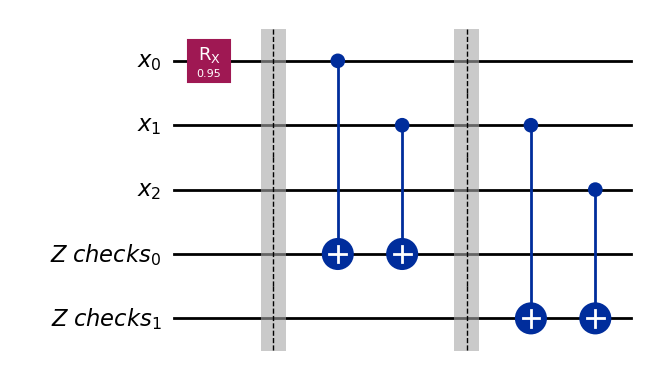

In [6]:
qubits_for_repetition_code = QuantumRegister(size=3, name="x")

repetition_code_circuit = QuantumCircuit(qubits_for_repetition_code, name="3-qubit Repetition code")

# qubits, by default, are initialized in the all-zero state, which is the logical zero for this code

# add ancillas for syndromes
qubits_for_X_checks = AncillaRegister(size=2, name=f"Z checks")
repetition_code_circuit.add_register(qubits_for_X_checks)

# add a random X error to random location
epsilon = np.pi * np.random.rand(1)[0]
location = np.random.randint(3)

repetition_code_circuit.rx(epsilon, qubits_for_repetition_code[location])

repetition_code_circuit.barrier()

# extract sydromes
# for Z01
repetition_code_circuit.cx(qubits_for_repetition_code[0], qubits_for_X_checks[0])
repetition_code_circuit.cx(qubits_for_repetition_code[1], qubits_for_X_checks[0])

repetition_code_circuit.barrier()

# for Z12
repetition_code_circuit.cx(qubits_for_repetition_code[1], qubits_for_X_checks[1])
repetition_code_circuit.cx(qubits_for_repetition_code[2], qubits_for_X_checks[1])

repetition_code_circuit.draw(output="mpl")

# add classical bits, measurements, and fixing

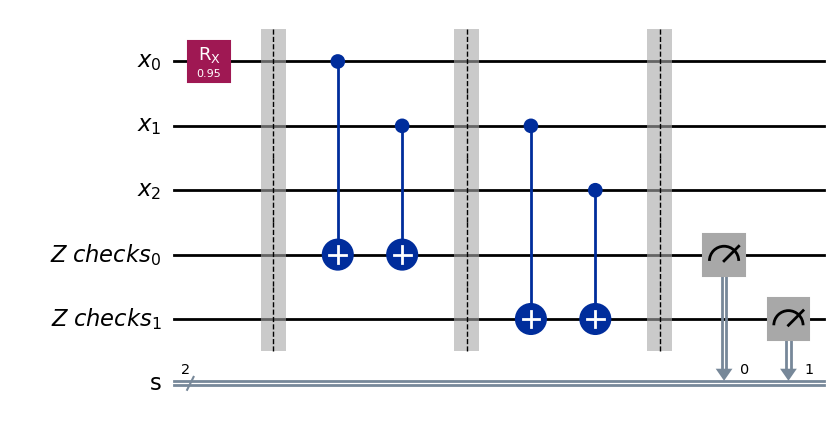

In [7]:
syndromes = ClassicalRegister(2, name="s")
repetition_code_circuit.add_register(syndromes)

repetition_code_circuit.barrier()

# measure
repetition_code_circuit.measure(qubits_for_X_checks, syndromes)



repetition_code_circuit.draw(output="mpl")

## Based on the measurement, fix!

### Measure syndromes and fix with if_test:

$(s_0, s_1) = (1, 0)$ means error on first qubit

$(s_0, s_1) = (1, 1)$ means error on second qubit

$(s_0, s_1) = (0, 1)$ means error on third qubit

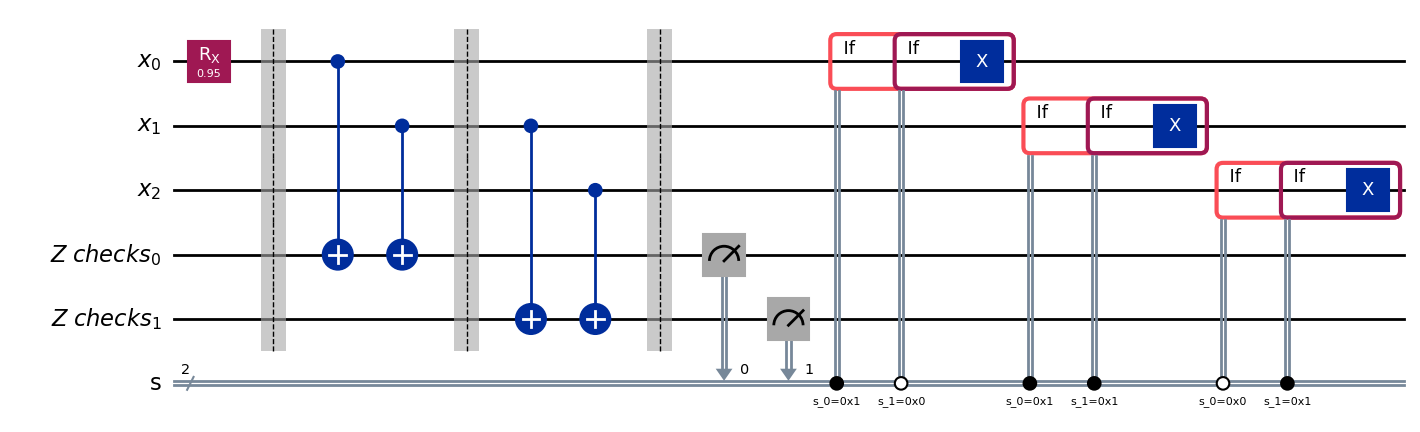

In [8]:
for idx in range(3):
    # computing which syndromes mean that the idx'th qubits needs an X fix
    if idx == 0:
        s0, s1 = 1, 0
    elif idx == 1:
        s0, s1 = 1, 1
    else:
        s0, s1 = 0, 1
    with repetition_code_circuit.if_test((syndromes[0], s0)):
        with repetition_code_circuit.if_test((syndromes[1], s1)):
            repetition_code_circuit.x(qubits_for_repetition_code[idx]) # physical X on the idx'th qubit

repetition_code_circuit.draw(output="mpl")

### Measure the data qubits to see if the fix was good!

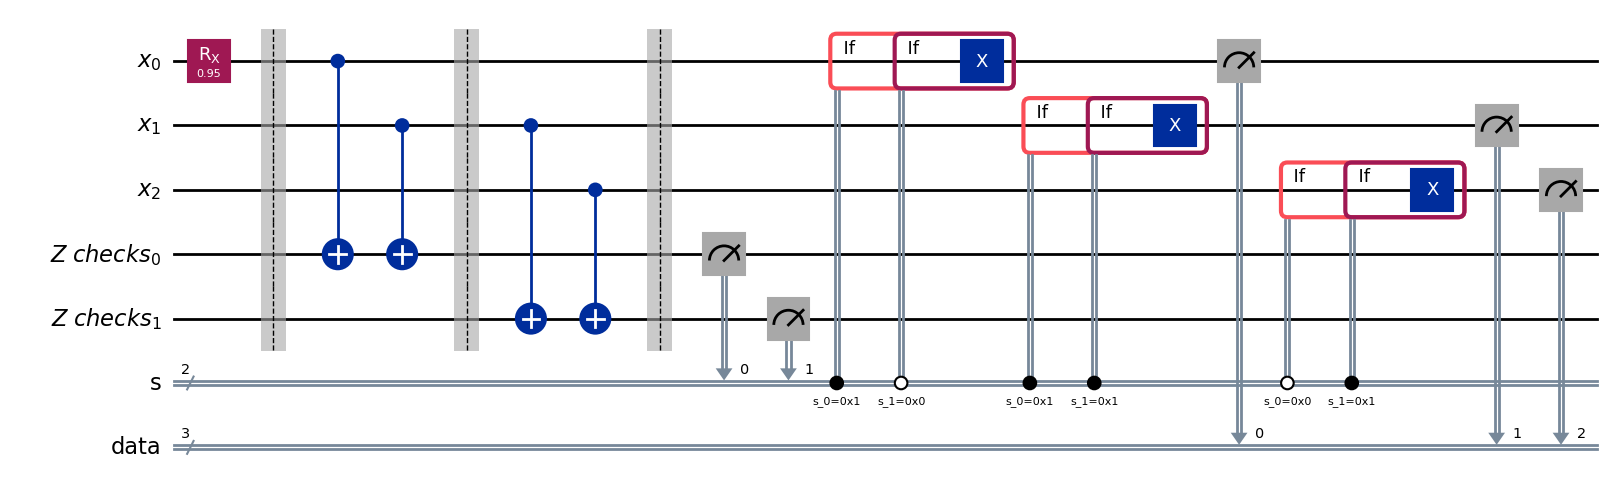

In [9]:
classical_register_for_data = ClassicalRegister(3, name="data")
repetition_code_circuit.add_register(classical_register_for_data)


# measure
repetition_code_circuit.measure(qubits_for_repetition_code, classical_register_for_data)



repetition_code_circuit.draw(output="mpl")

In [10]:
simulator = AerSimulator()

In [11]:
# Transpile the circuit for the backend
compiled_circuit = transpile(repetition_code_circuit, simulator)

# Run the circuit
job = simulator.run(compiled_circuit, shots=1000)

# Get the measurement counts
counts = job.result().get_counts()

{'000 01': 201, '000 00': 799}

### the first 3 bits should all be zero (all errors fixed), even if there are syndromes, that is, nonzeros in the other two bits:

In [12]:
counts

{'000 01': 201, '000 00': 799}

# Shor's code

stabilizer group
\begin{equation}
    S = \left\{ X_{01}, X_{12}, X_{34}, X_{45}, X_{67}, X_{78}, Z_{012345}, Z_{345678} \right\}.
\end{equation}

### prepare the logical zero state:

\begin{align}
    | 0_L \rangle   &= \left( \tfrac{1}{\sqrt{2}} \left( | 000 \rangle + | 111 \rangle \right) \right)^{\otimes 3} \\
                    &= \tfrac{1}{\sqrt{8}} \left( | 000000000 \rangle + | 111000000 \rangle + | 000111000 \rangle + | 111111000 \rangle + | 000000111 \rangle + | 111000111 \rangle + | 000111111 \rangle + | 111111111 \rangle \right).
\end{align}

The circuit below assumes that the 0th qubit is in an arbitrary state $| \psi \rangle = \alpha | 0 \rangle + \beta | 1 \rangle$ and the other qubits are initialized to zero. Then it returns $| \psi_L^{Shor} \rangle = \alpha | 0_L^{Shor} \rangle + \beta | 1_L^{Shor} \rangle$.

We use $\alpha = 1$ and $\beta = 0$, that is, $| \psi \rangle = | 0 \rangle \mapsto | \psi_L^{Shor} \rangle = | 0_L^{Shor} \rangle$.

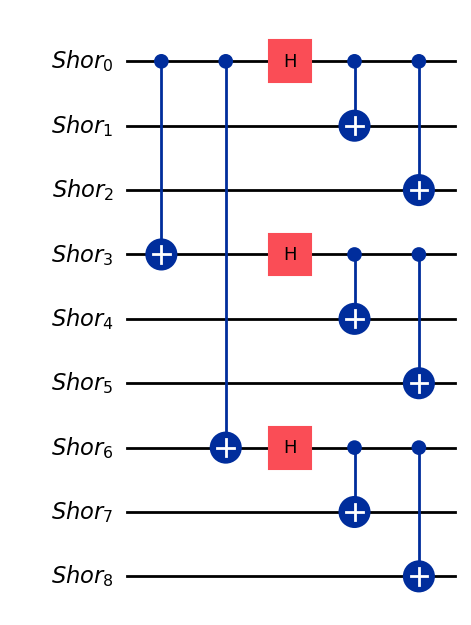

In [13]:
qubits_for_shors_code = QuantumRegister(size=9, name="Shor")

shors_code_preparator_circuit = QuantumCircuit(qubits_for_shors_code, name="Shor's code")

shors_code_preparator_circuit.cx(qubits_for_shors_code[0], qubits_for_shors_code[3])
shors_code_preparator_circuit.cx(qubits_for_shors_code[0], qubits_for_shors_code[6])
shors_code_preparator_circuit.h(qubits_for_shors_code[::3])

for idx in range(3):
    shors_code_preparator_circuit.cx(qubits_for_shors_code[3 * idx], qubits_for_shors_code[3 * idx + 1])
    shors_code_preparator_circuit.cx(qubits_for_shors_code[3 * idx], qubits_for_shors_code[3 * idx + 2])

shors_code_preparator = shors_code_preparator_circuit.to_gate()
shors_code_preparator.label = "Shor preparator"

shors_code_preparator_circuit.draw(output="mpl")

### check is we indeed got the right components:

In [14]:
logical_zero = Statevector(shors_code_preparator_circuit).data
print(logical_zero)
print(np.where(logical_zero)[0])

[0.35355339+0.j 0.        +0.j 0.        +0.j 0.        +0.j
 0.        +0.j 0.        +0.j 0.        +0.j 0.35355339+0.j
 0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j
 0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j
 0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j
 0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j
 0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j
 0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j
 0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j
 0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j
 0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j
 0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j
 0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j
 0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j
 0.35355339+0.j 0.        +0.j 0.        +0.j 0.        +0.j
 0.        +0.j 0.        +0.j 0.        +0.j 0.35355339+0.j
 0.        +0.j 0.      

# Add the ancillas for syndromes

## $X$-checks / $Z$-type "stabilizers":

For example, `X check_0` checks the eigenvalue of $Z_{01}$, and so on...

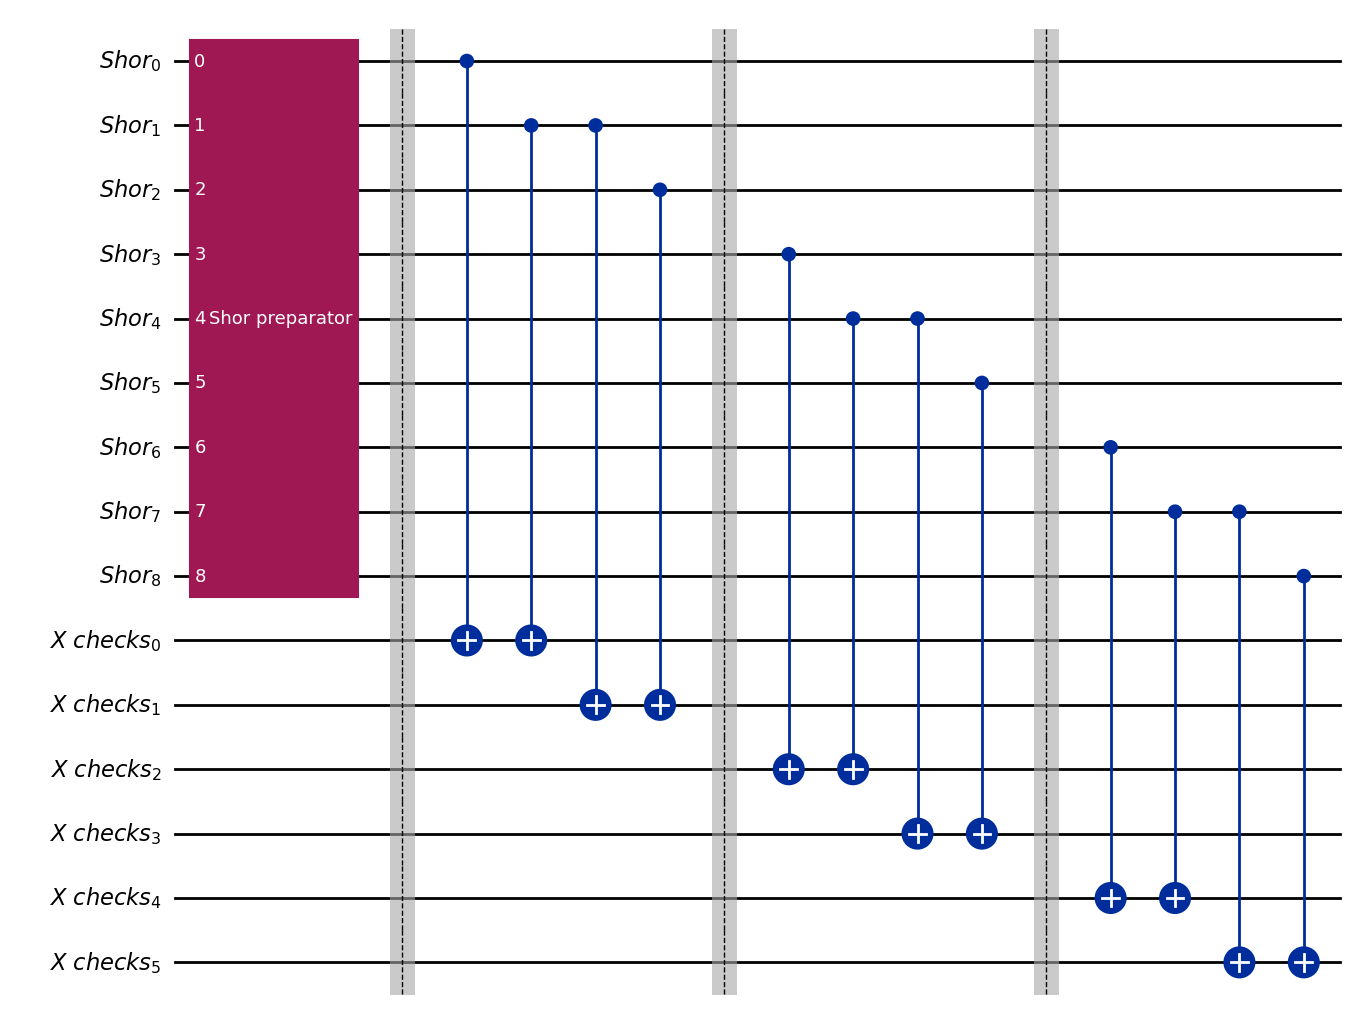

In [15]:
qubits_for_shors_code = QuantumRegister(size=9, name="Shor")

shors_code_circuit = QuantumCircuit(qubits_for_shors_code, name="Shor's code")

shors_code_circuit.compose(shors_code_preparator, inplace=True)

qubits_for_X_checks = AncillaRegister(size=6, name="X checks")
shors_code_circuit.add_register(qubits_for_X_checks)

for idx in range(3):
    shors_code_circuit.barrier()
    shors_code_circuit.cx(qubits_for_shors_code[3 * idx], qubits_for_X_checks[2 * idx])
    shors_code_circuit.cx(qubits_for_shors_code[3 * idx + 1], qubits_for_X_checks[2 * idx])

    shors_code_circuit.cx(qubits_for_shors_code[3 * idx + 1], qubits_for_X_checks[2 * idx + 1])
    shors_code_circuit.cx(qubits_for_shors_code[3 * idx + 2], qubits_for_X_checks[2 * idx + 1])



shors_code_circuit.draw(output="mpl")

## $Z$-checks / $X$-type "stabilizers":

In order to measure $X$-type stabilizers we use the following gadgets on each affected qubits:

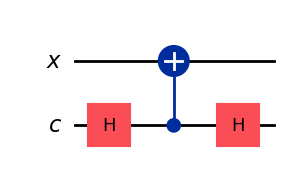

In [16]:
# note: this tiny circuit is just for demo, it won't be part of the Shor circuit
qubit_to_check = QuantumRegister(size=1, name="x")
stabilizer = AncillaRegister(size=1, name="c")

Z_check_gadget = QuantumCircuit(qubit_to_check, stabilizer)

Z_check_gadget.h(stabilizer)
Z_check_gadget.cx(stabilizer[0], qubit_to_check[0])
Z_check_gadget.h(stabilizer)

Z_check_gadget.draw(output="mpl")

Recall that the $X$-type stabilizers are $X_{012345}$ and $X_{345678}$, so you need to attach the above gadget for:

1. $x \in \{ 0, 1, 2, 3, 4, 5 \}$ and $s$ being the first $X$ check,
and
2. $x \in \{ 3, 4, 5, 6, 7, 8 \}$ and $s$ being the second $X$ check.

Note that $H^2 = \mathbb{I}$, thus consecutive Hadamards cancel.

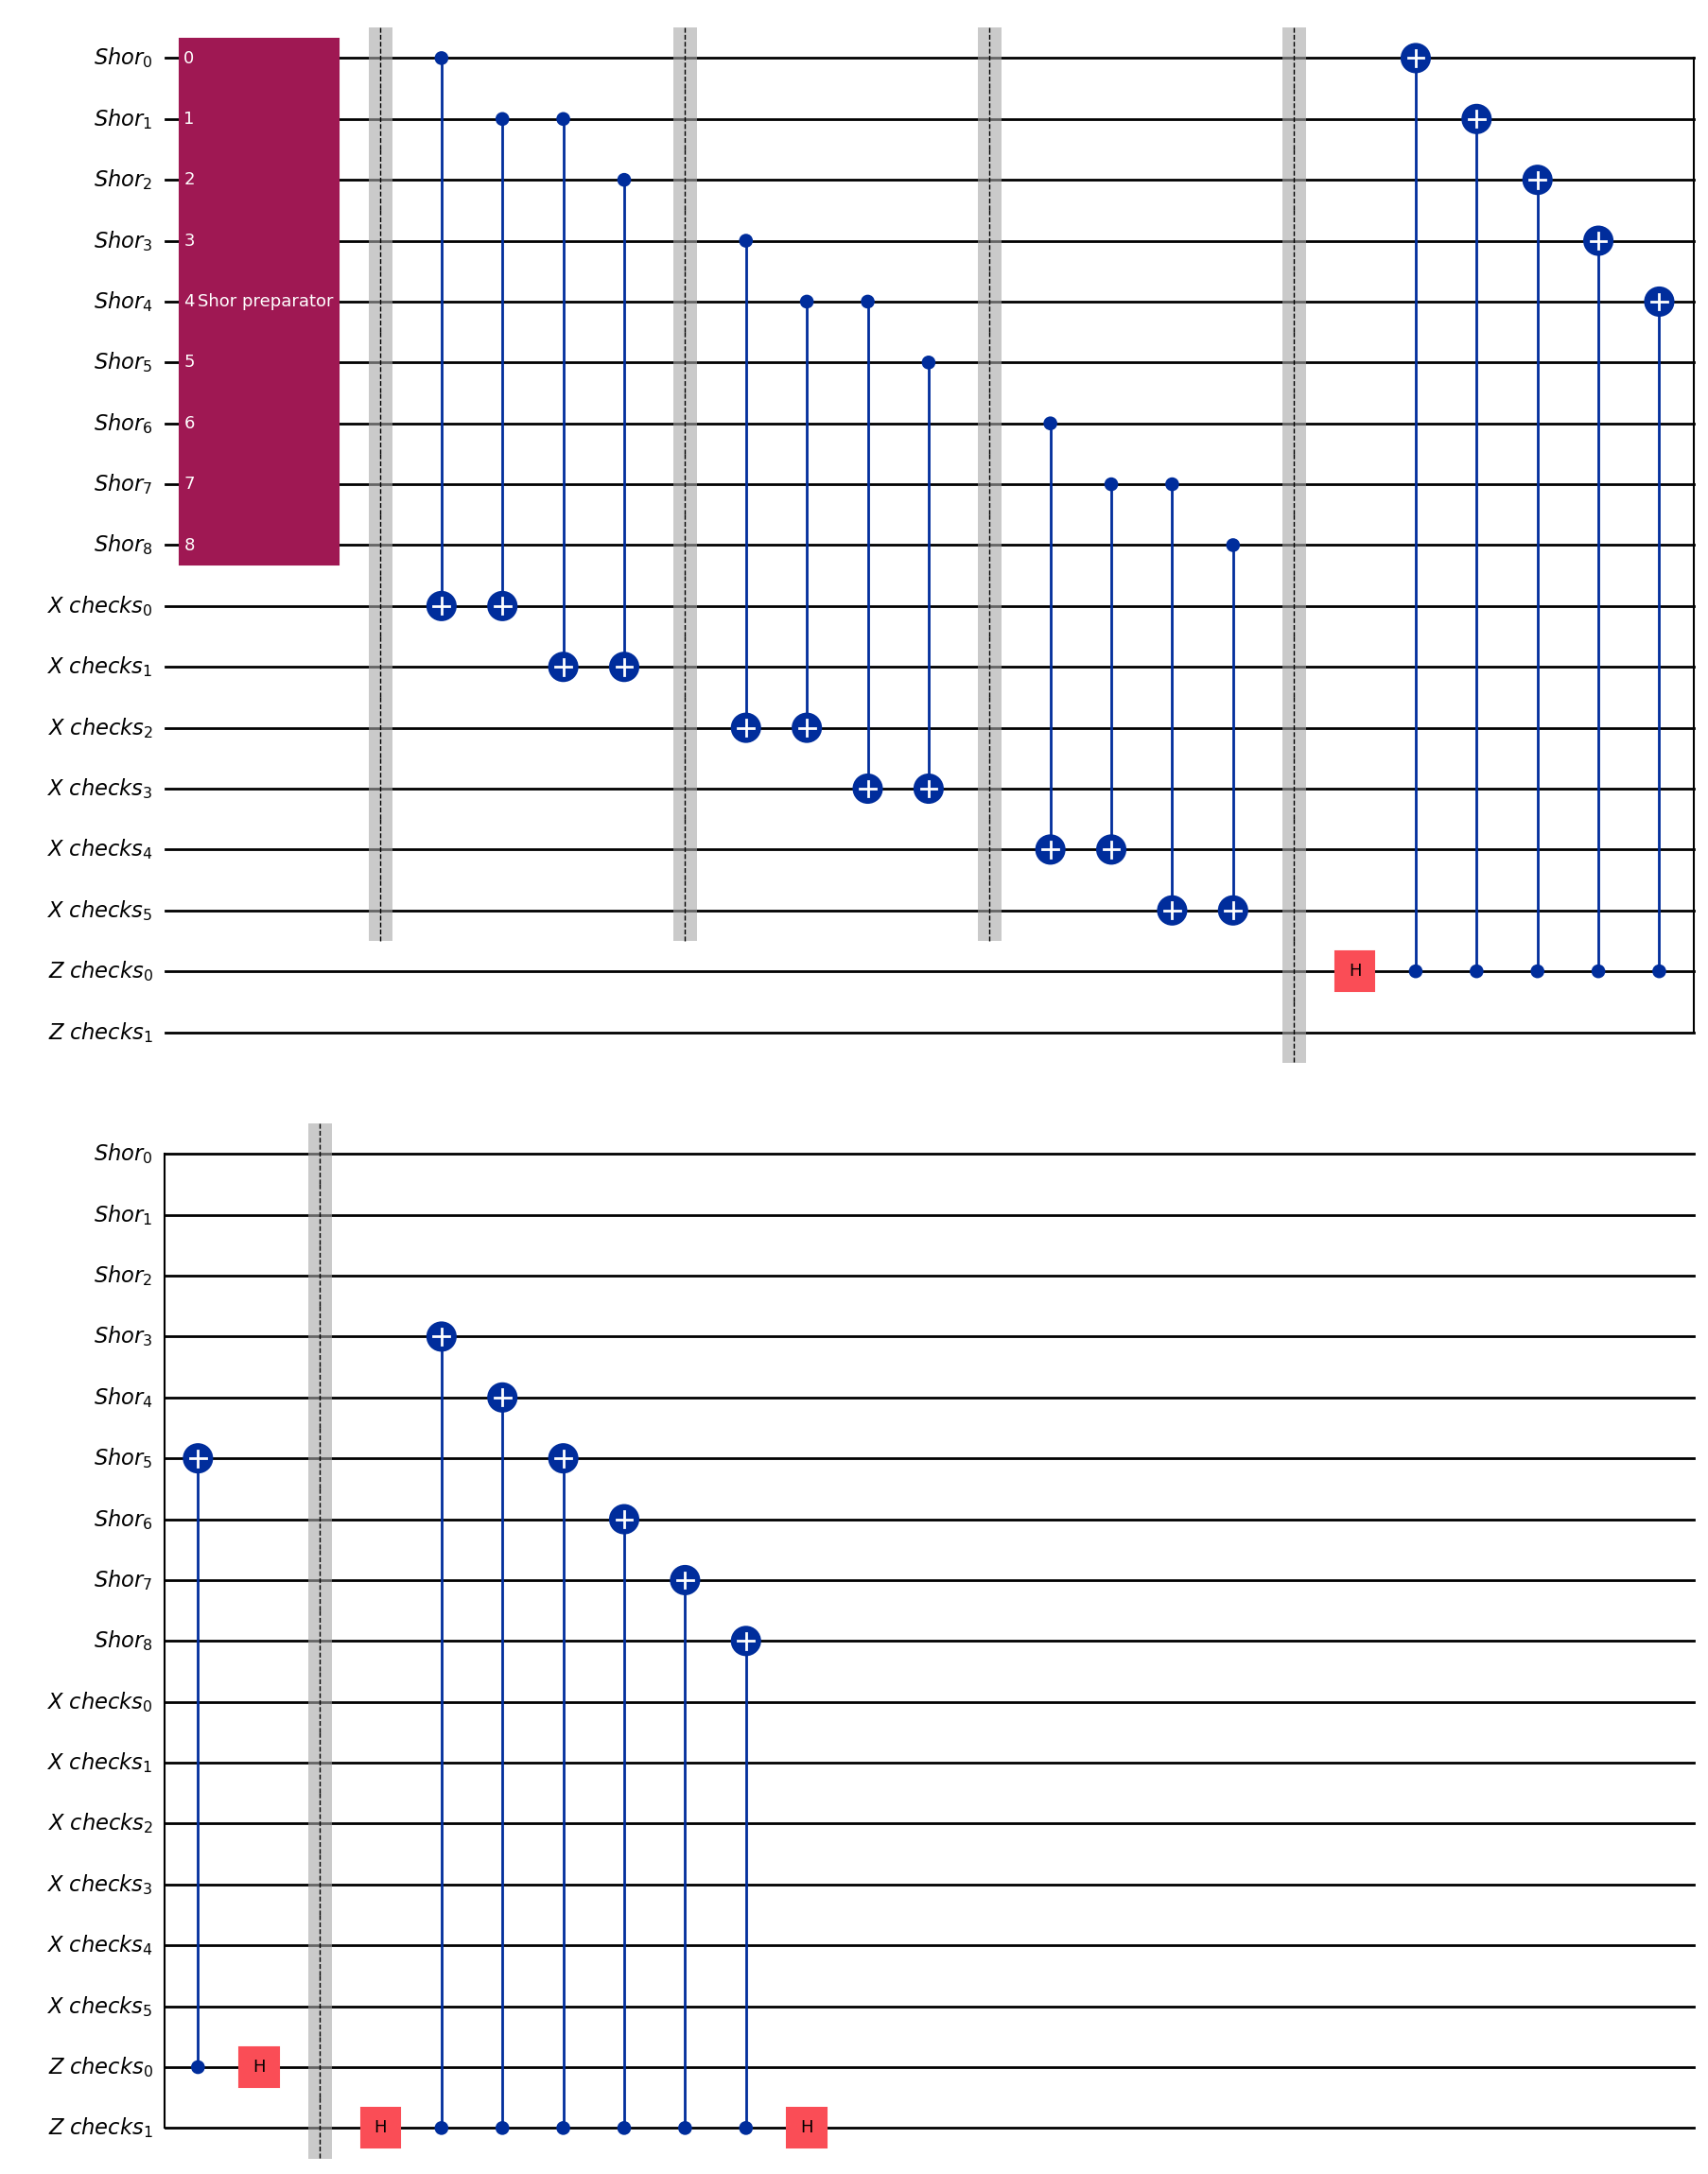

In [17]:
qubits_for_Z_checks = AncillaRegister(size=2, name=f"Z checks")
shors_code_circuit.add_register(qubits_for_Z_checks)

for idx in range(2):
    shors_code_circuit.barrier()
    shors_code_circuit.h(qubits_for_Z_checks[idx])
    for jdx in range(6):
        shors_code_circuit.cx(qubits_for_Z_checks[idx], qubits_for_shors_code[3 * idx + jdx])
    shors_code_circuit.h(qubits_for_Z_checks[idx])




shors_code_circuit.draw(output="mpl")

# testing:

In [18]:
# random parameters for testing

angles = np.pi * np.random.rand(3)
location = np.random.randint(9)

angles, location

(array([2.11794008, 1.15700532, 0.88435705]), 4)

# restart the construction and add the random errors

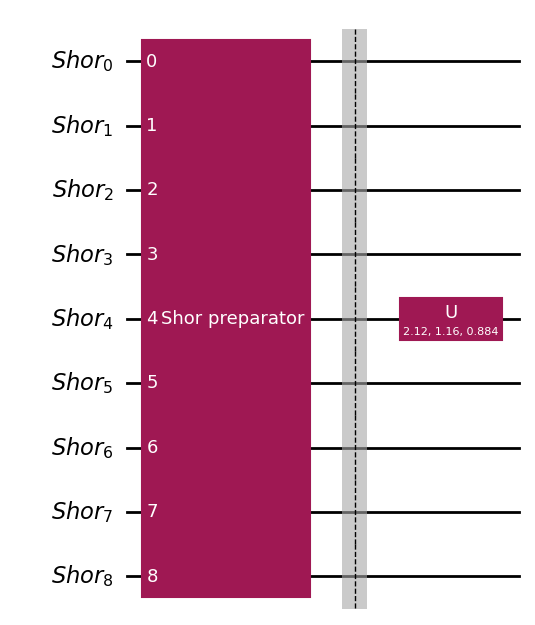

In [19]:
qubits_for_shors_code = QuantumRegister(size=9, name="Shor")

shors_code_circuit = QuantumCircuit(qubits_for_shors_code, name="Shor's code")

shors_code_circuit.compose(shors_code_preparator, inplace=True)

shors_code_circuit.barrier()

# add the random error to the random location
shors_code_circuit.u(angles[0], angles[1], angles[2], qubits_for_shors_code[location])

shors_code_circuit.draw(output="mpl")

# rebuild the circuit as before

## add the stabilizer checks

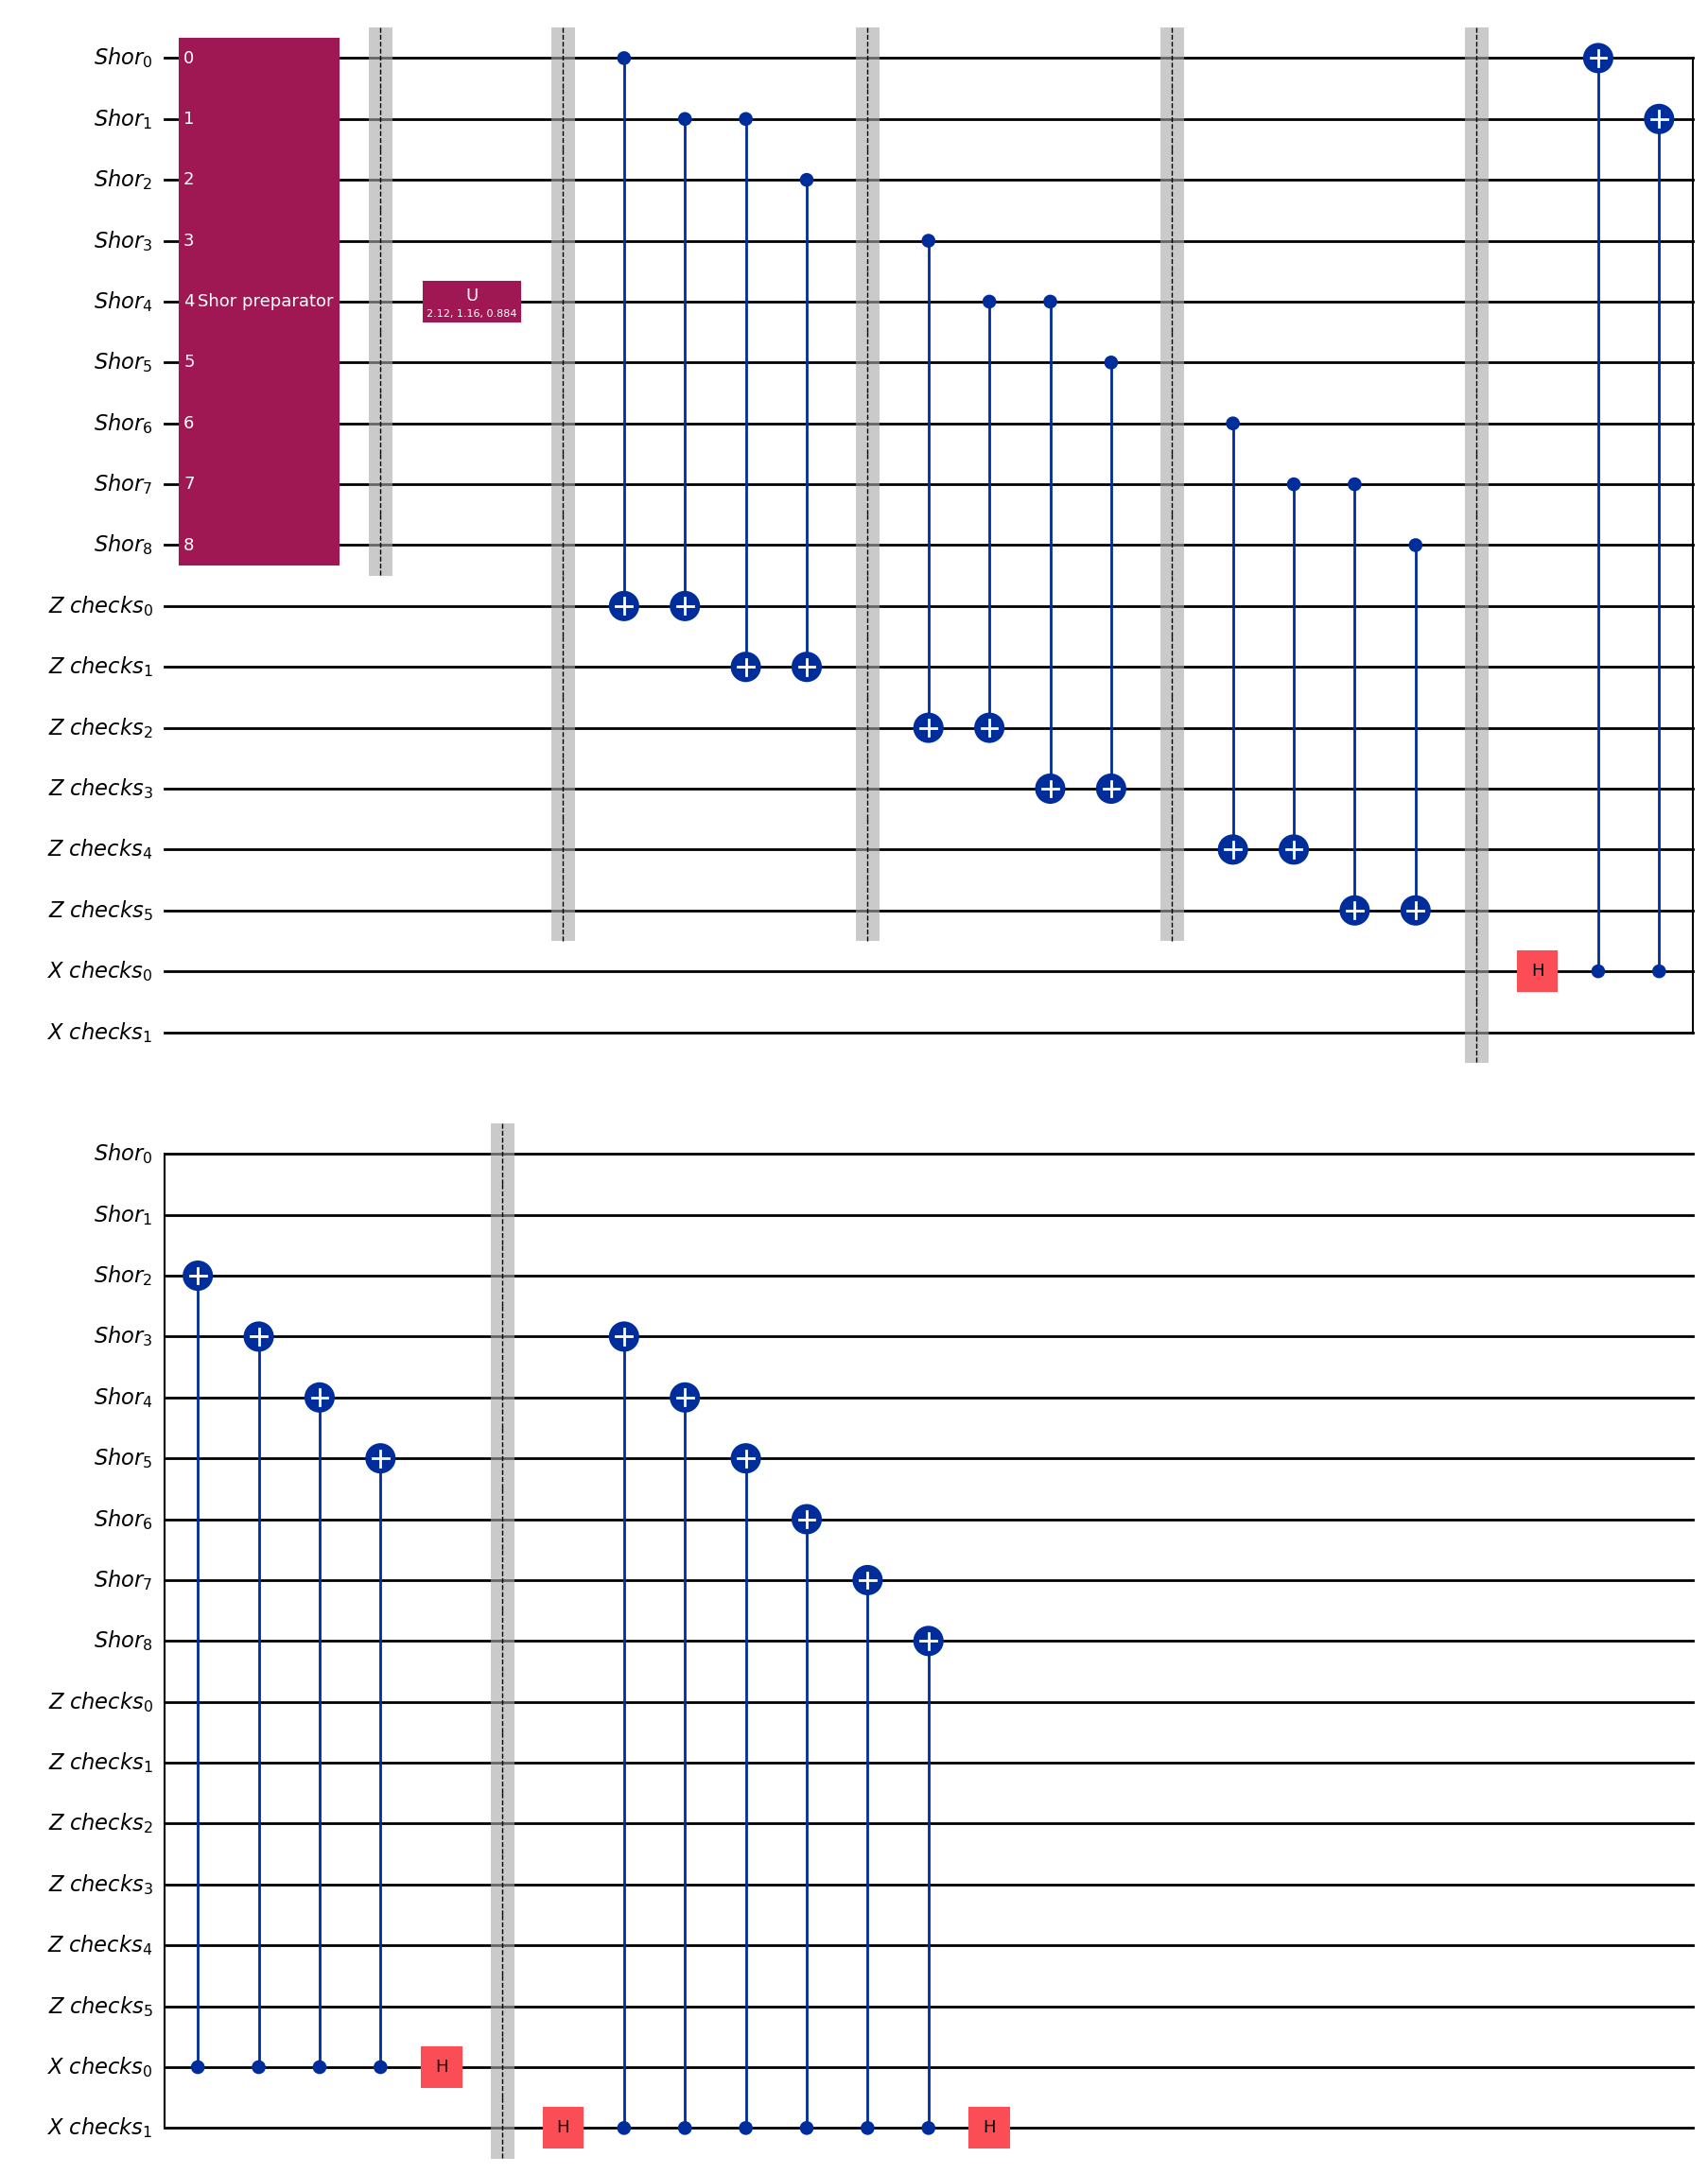

In [20]:
qubits_for_X_checks = AncillaRegister(size=6, name=f"Z checks")
shors_code_circuit.add_register(qubits_for_X_checks)

for idx in range(3):
    shors_code_circuit.barrier()
    shors_code_circuit.cx(qubits_for_shors_code[3 * idx], qubits_for_X_checks[2 * idx])
    shors_code_circuit.cx(qubits_for_shors_code[3 * idx + 1], qubits_for_X_checks[2 * idx])

    shors_code_circuit.cx(qubits_for_shors_code[3 * idx + 1], qubits_for_X_checks[2 * idx + 1])
    shors_code_circuit.cx(qubits_for_shors_code[3 * idx + 2], qubits_for_X_checks[2 * idx + 1])


qubits_for_Z_checks = AncillaRegister(size=2, name=f"X checks")
shors_code_circuit.add_register(qubits_for_Z_checks)

for idx in range(2):
    shors_code_circuit.barrier()
    shors_code_circuit.h(qubits_for_Z_checks[idx])
    for jdx in range(6):
        shors_code_circuit.cx(qubits_for_Z_checks[idx], qubits_for_shors_code[3 * idx + jdx])
    shors_code_circuit.h(qubits_for_Z_checks[idx])



shors_code_circuit.draw(output="mpl")

## Add classical bits and measurement instructions

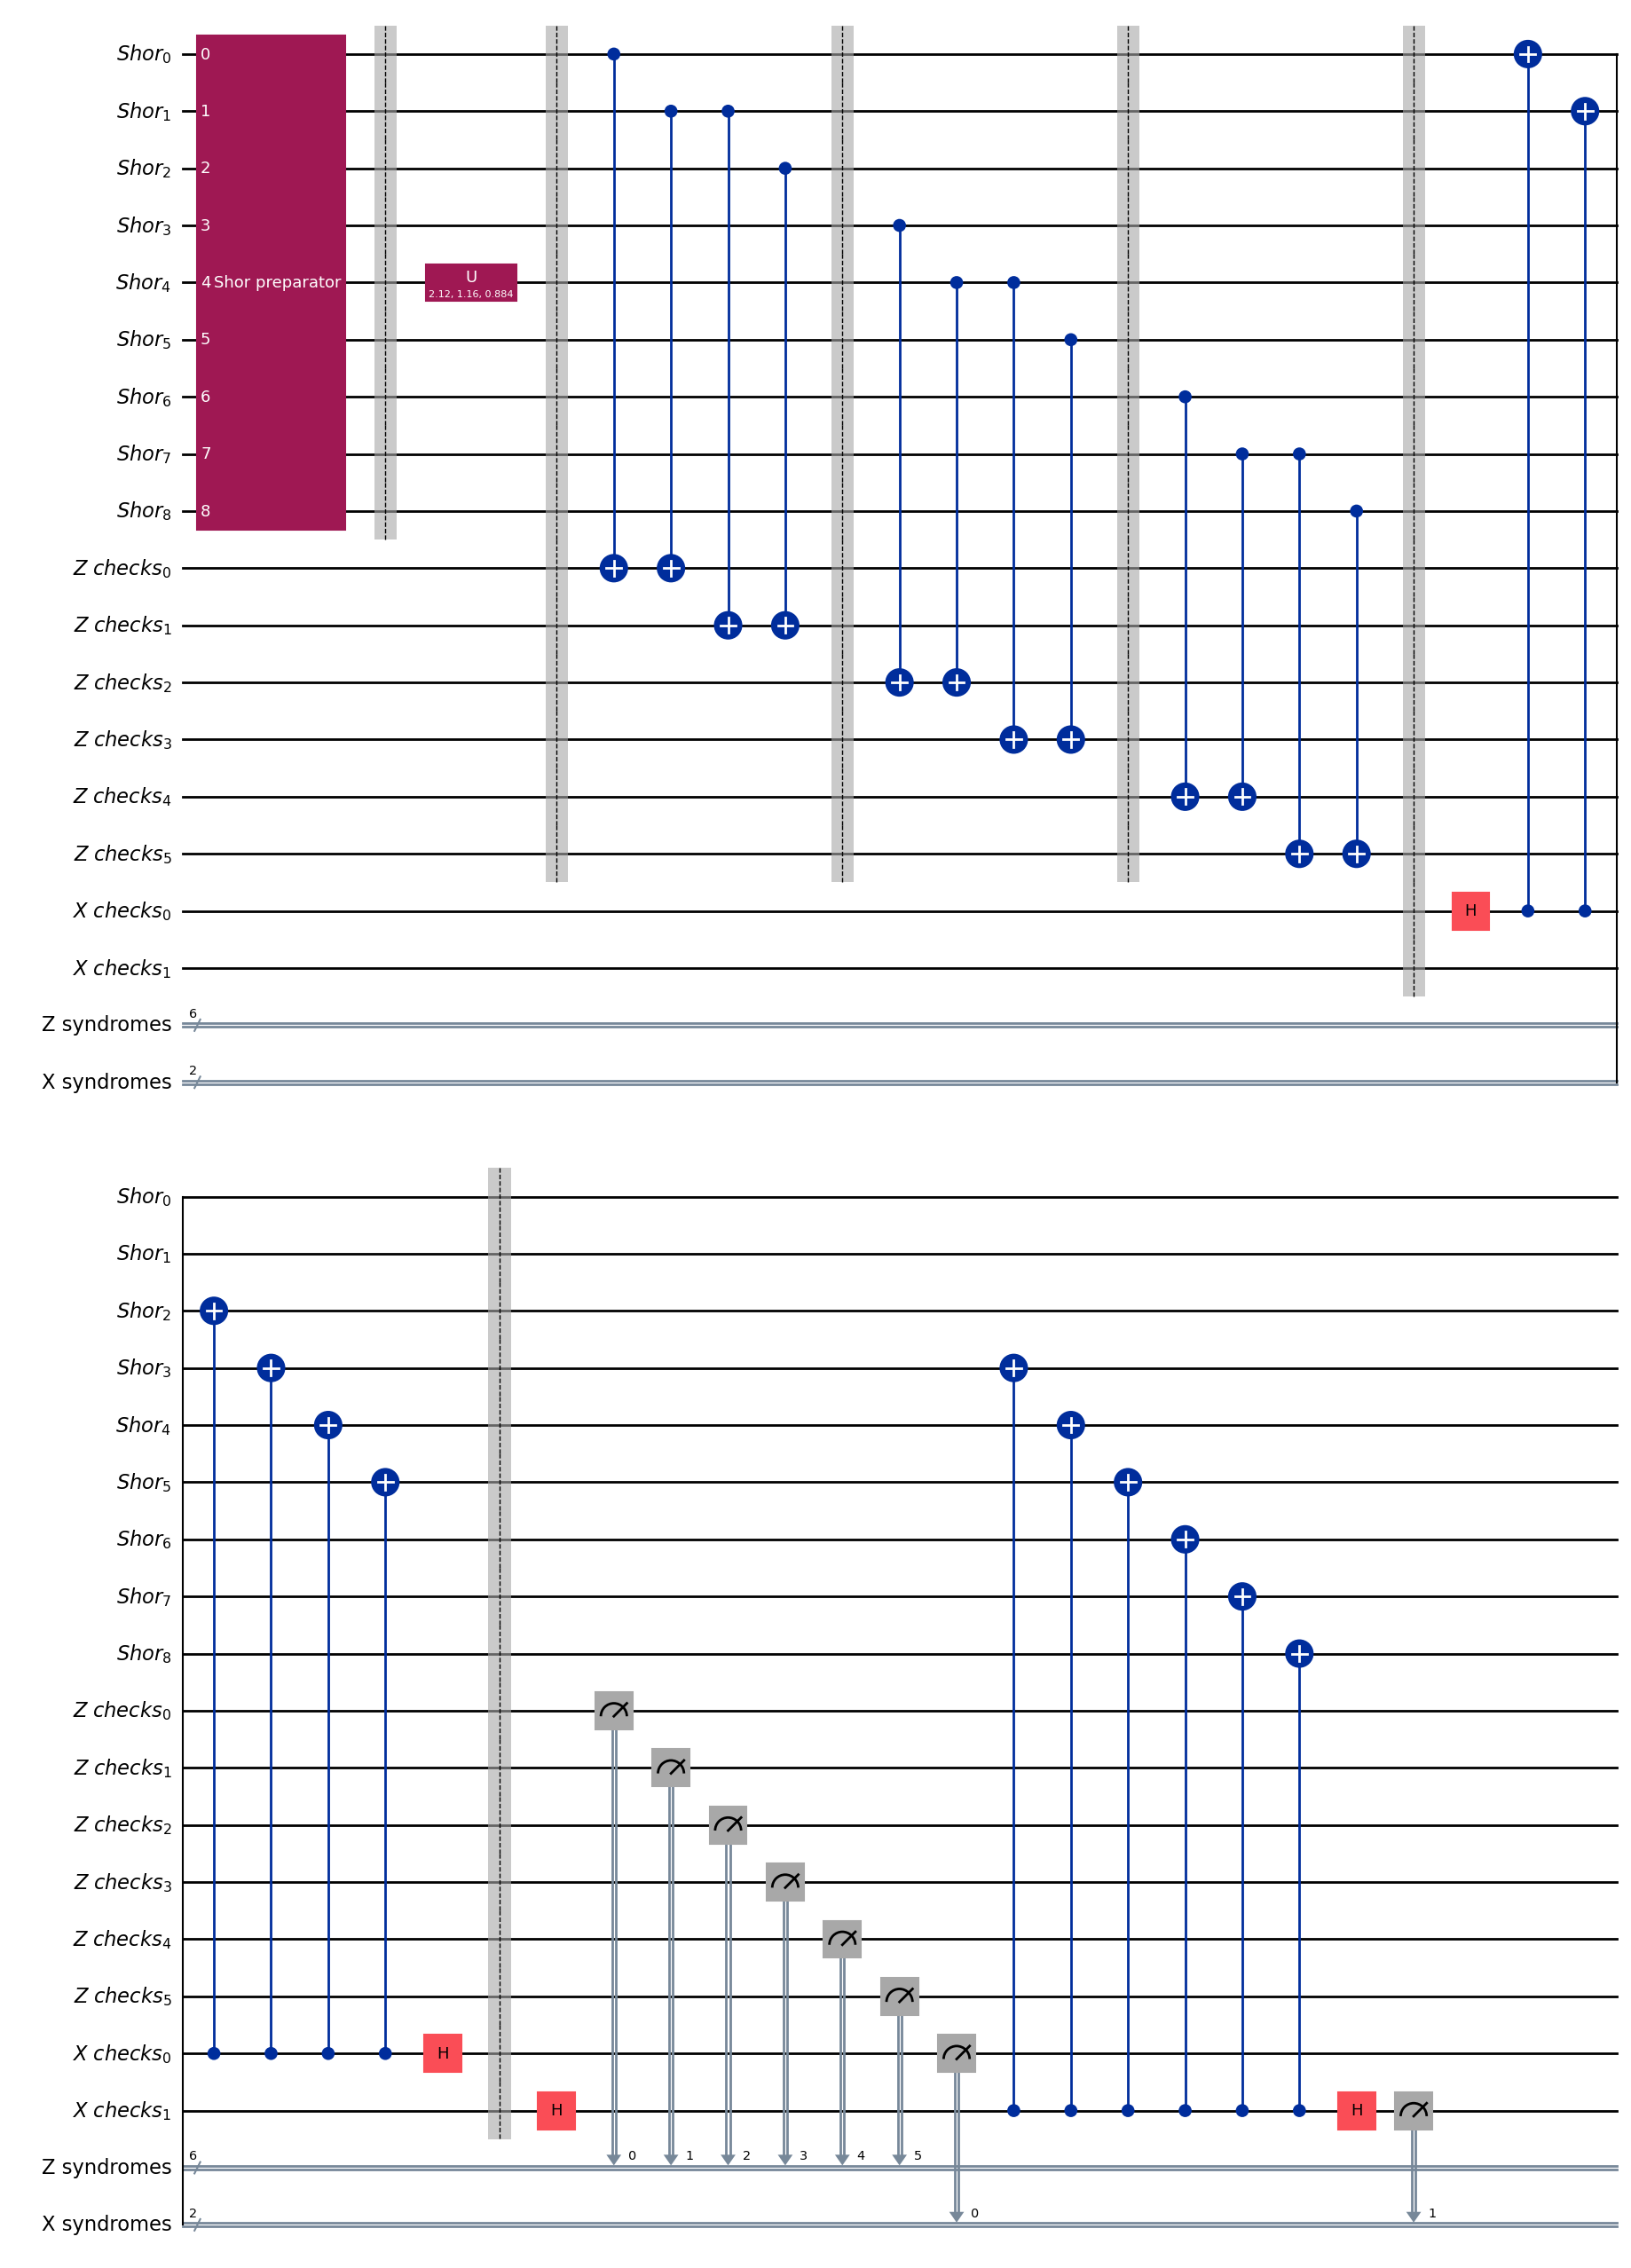

In [21]:
X_syndrome_measurements = ClassicalRegister(6, name=f"Z syndromes")
shors_code_circuit.add_register(X_syndrome_measurements)

Z_syndrome_measurements = ClassicalRegister(2, name=f"X syndromes")
shors_code_circuit.add_register(Z_syndrome_measurements)



shors_code_circuit.measure(qubits_for_X_checks, X_syndrome_measurements)
shors_code_circuit.measure(qubits_for_Z_checks, Z_syndrome_measurements)



shors_code_circuit.draw(output="mpl")

## Measure syndromes and fix with if_test:

$(s_0, s_1) = (1, 0)$ means error on first qubit

$(s_0, s_1) = (1, 1)$ means error on second qubit

$(s_0, s_1) = (0, 1)$ means error on third qubit

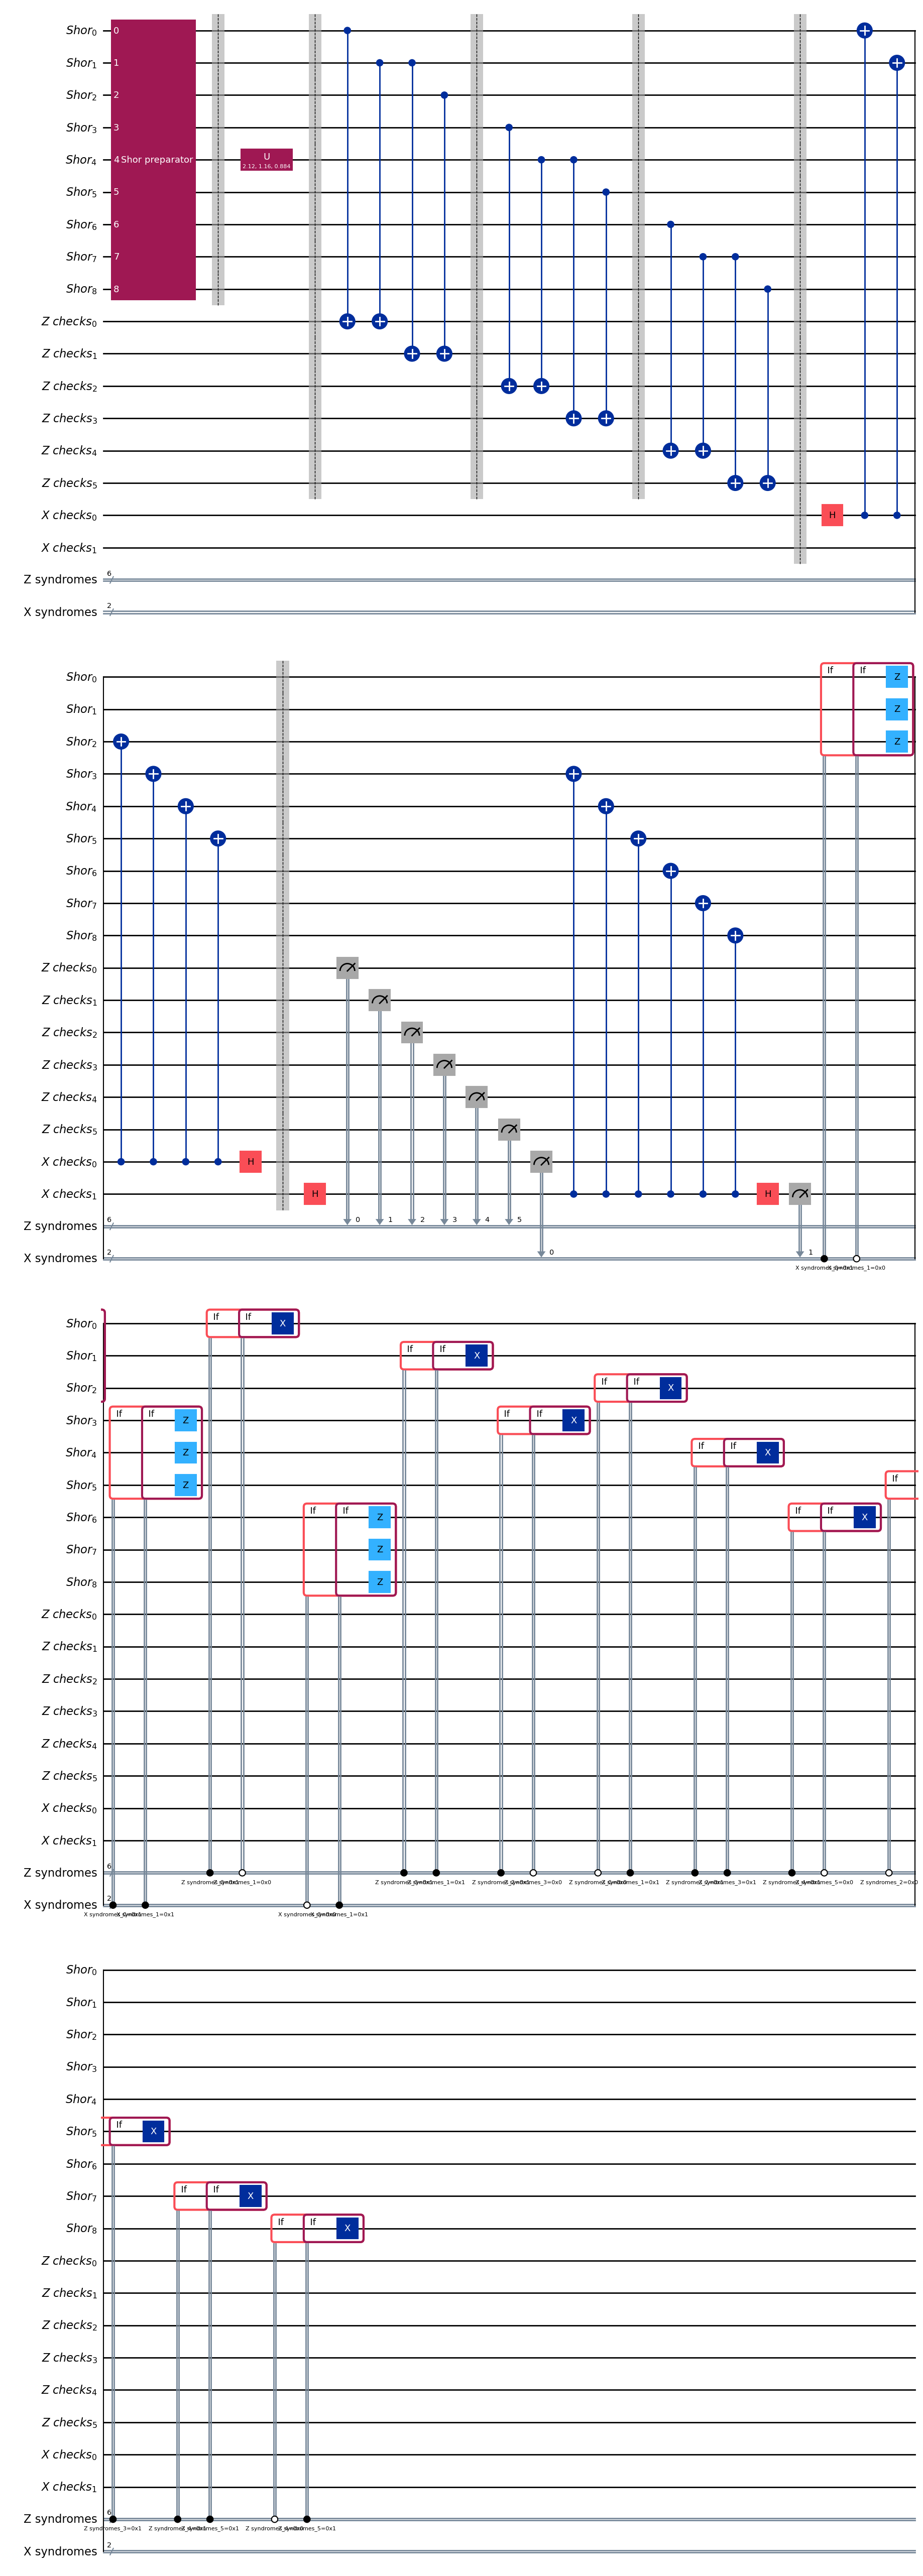

In [22]:
# add the X checks
with shors_code_circuit.if_test((Z_syndrome_measurements[0], 1)):
    with shors_code_circuit.if_test((Z_syndrome_measurements[1], 0)):
        shors_code_circuit.z(qubits_for_shors_code[:3]) # logical Z on first triple



with shors_code_circuit.if_test((Z_syndrome_measurements[0], 1)):
    with shors_code_circuit.if_test((Z_syndrome_measurements[1], 1)):
        shors_code_circuit.z(qubits_for_shors_code[3:6]) # logical Z on second triple



with shors_code_circuit.if_test((Z_syndrome_measurements[0], 0)):
    with shors_code_circuit.if_test((Z_syndrome_measurements[1], 1)):
        shors_code_circuit.z(qubits_for_shors_code[6:]) # logical Z on third triple


# add the Z checks
for idx in range(9):
    a, b = idx // 3, idx%3 # a is the triple's number and b is the the qubit's number within the triple
    # computing which syndromes mean that the idx'th qubits needs an X fix
    if b == 0:
        s0, s1 = 1, 0
    elif b == 1:
        s0, s1 = 1, 1
    else:
        s0, s1 = 0, 1
    with shors_code_circuit.if_test((X_syndrome_measurements[2 * a], s0)):
        with shors_code_circuit.if_test((X_syndrome_measurements[2 * a + 1], s1)):
            shors_code_circuit.x(qubits_for_shors_code[idx]) # physical X on the idx'th qubit



shors_code_circuit.draw(output="mpl")

# finally "unprepare" logical zero

if the error correction worked, after this the first 9 qubits should all be in state zero

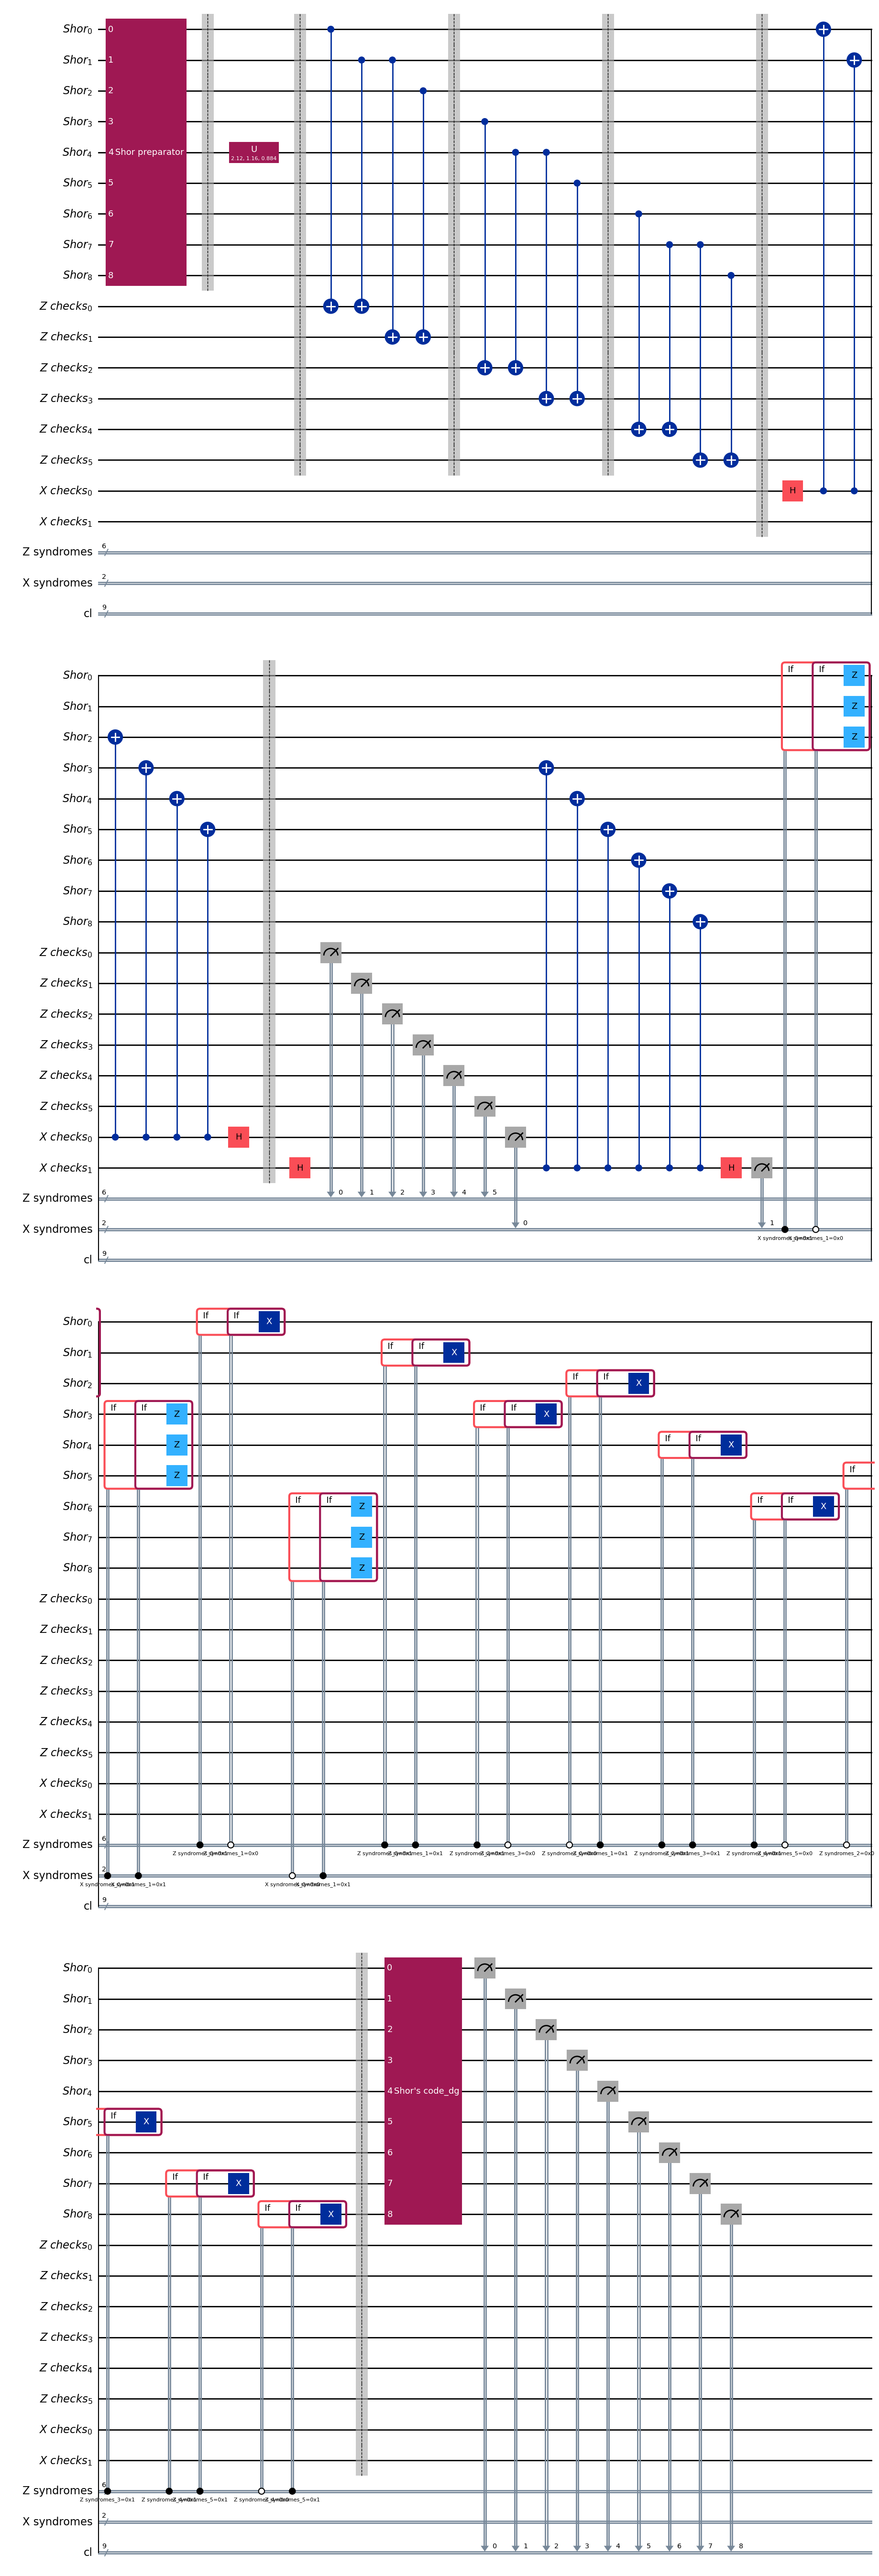

In [25]:
shors_code_circuit.barrier()

shors_code_circuit.compose(shors_code_preparator.inverse(), inplace=True)



qubit_measurements = ClassicalRegister(9, name=f"cl")
shors_code_circuit.add_register(qubit_measurements)

shors_code_circuit.measure(qubits_for_shors_code, qubit_measurements)



shors_code_circuit.draw(output="mpl")

In [26]:
# Transpile the circuit for the backend
compiled_circuit = transpile(shors_code_circuit, simulator)

# Run the circuit
job = simulator.run(compiled_circuit, shots=100)

# Get the measurement counts
counts = job.result().get_counts()

### the first 9 bits should all be zero (all errors fixed), even if there are syndromes, that is, nonzeros in the other 2 + 6 bits:

In [27]:
counts

{'000000000 00 001100': 3,
 '000000000 11 000000': 91,
 '000000000 00 000000': 29,
 '000000000 11 001100': 377}